In [14]:
import os
import cv2
import numpy as np
import time, os, sys
import json
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl

from urllib.parse import urlparse
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import lstsq
from scipy.spatial import distance
from skimage.measure import find_contours
from skimage.morphology import disk, dilation
from scipy.ndimage.morphology import binary_dilation
from scipy.spatial.distance import cdist

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core
from cellpose import utils
from PIL import Image, ImageOps


use_GPU = core.use_gpu()
# print('>>> GPU activated? %d'%use_GPU)

# # call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

files = ['../test_data/test_imgs_single_nuclei/0701_reg001_cyc002_ch001_DAPI-02_13.png']

#imgs = [skimage.io.imread(f) for f in files]
imgs = [np.asarray(Image.open(f)) for f in files]
nimg = len(imgs)

model = models.Cellpose(gpu=use_GPU, model_type='cyto')

channels = [[0,0]]

masks, flows, styles, diams = model.eval(imgs, diameter=None, flow_threshold=None, channels=channels)

masks = [_masks.astype('int32') for _masks in masks]

2022-02-22 20:27:54,388 [INFO] ** TORCH CUDA version installed and working. **
2022-02-22 20:27:54,391 [INFO] WRITING LOG OUTPUT TO /home/master/09/chacotw/.cellpose/run.log
2022-02-22 20:27:54,398 [INFO] ** TORCH CUDA version installed and working. **
2022-02-22 20:27:54,400 [INFO] >>>> using GPU
2022-02-22 20:27:54,475 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~


/home/master/09/chacotw/miniconda3/envs/unet/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2022-02-22 20:27:58,826 [INFO] estimated cell diameter(s) in 4.35 sec
2022-02-22 20:27:58,827 [INFO] >>> diameter(s) = 
2022-02-22 20:27:58,828 [INFO] [17.09, ]
2022-02-22 20:27:58,829 [INFO] ~~~ FINDING MASKS ~~~
2022-02-22 20:28:01,033 [INFO] >>>> TOTAL TIME 6.56 sec


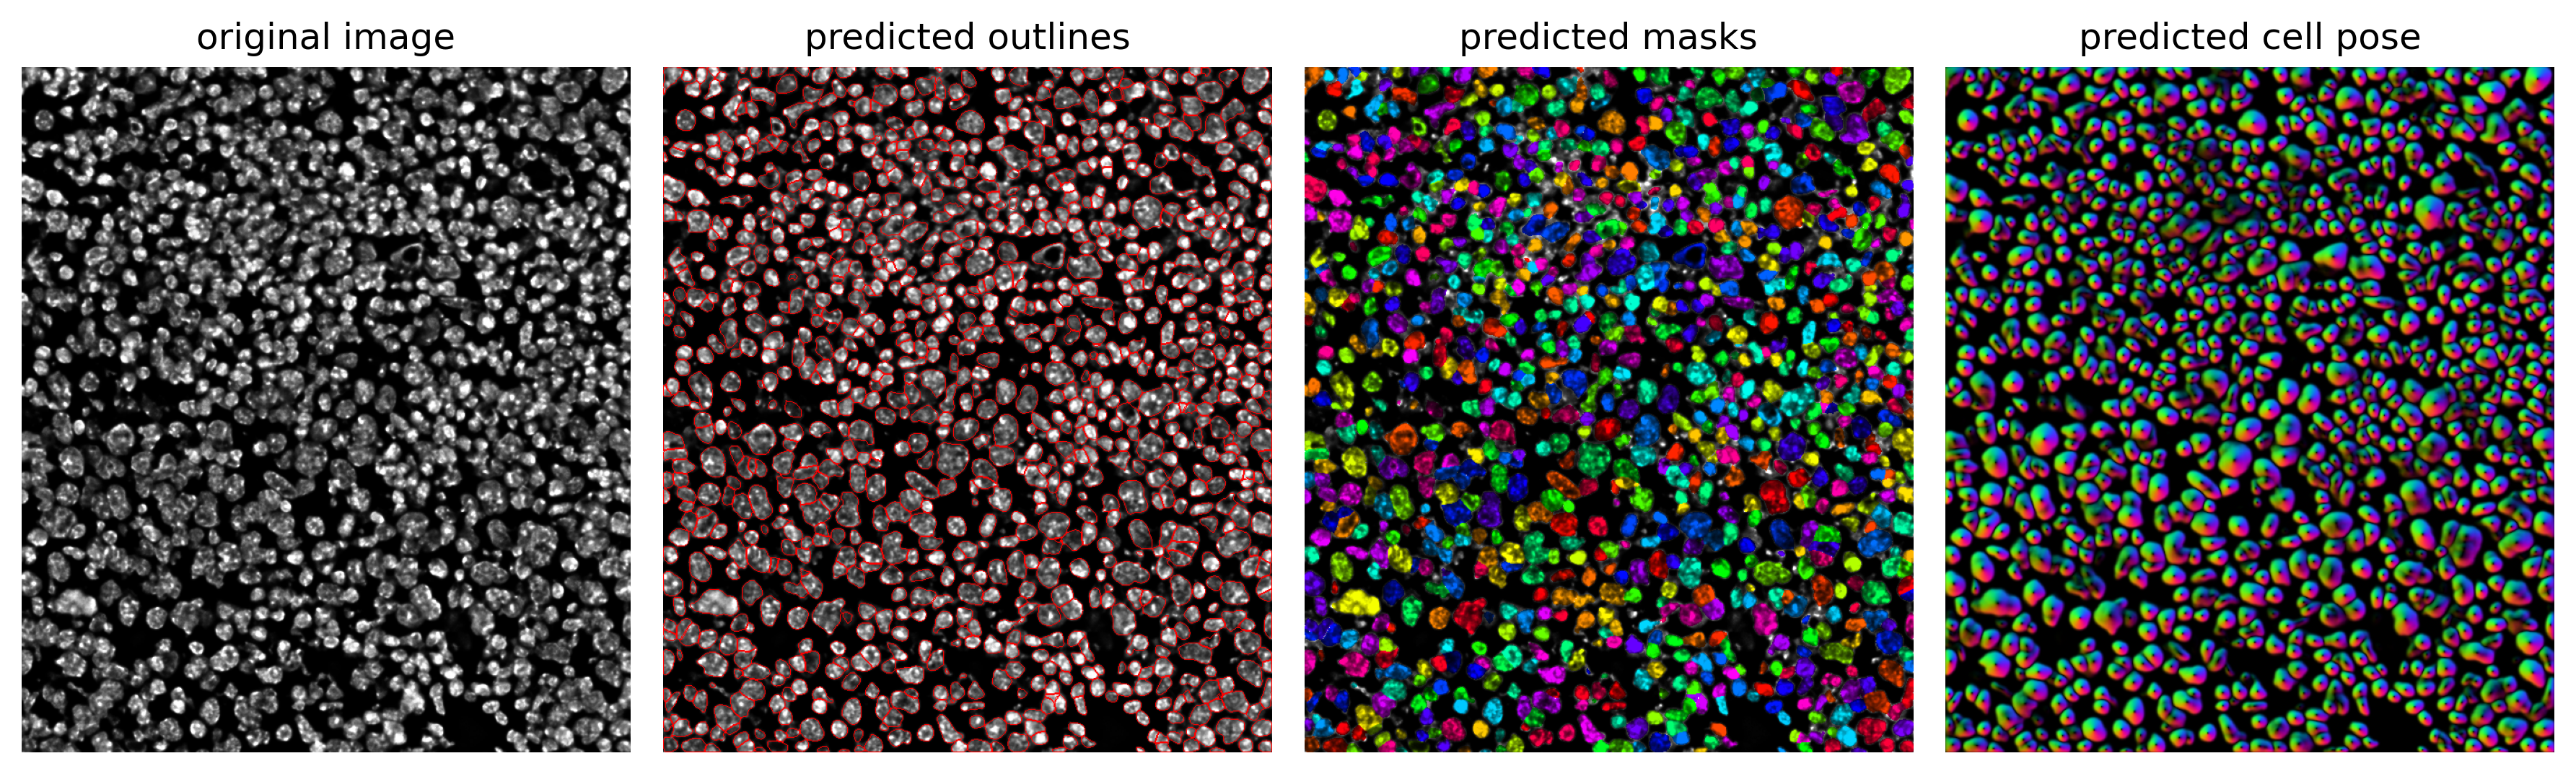

In [15]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

In [16]:
def grow_masks(masks,growth, num_neighbors = 30):

    num_masks = len(np.unique(masks)) - 1
    
    bb_mins, bb_maxes = compute_boundbox(masks)

    print("Sequential growth selected")
    Y, X = masks.shape
    struc = disk(1)
    for _ in range(growth):
        for i in range(num_masks):
            mins = bb_mins[i]
            maxes = bb_maxes[i]
            minY, minX, maxY, maxX = mins[0] - 3*growth, mins[1] - 3*growth, maxes[0] + 3*growth, maxes[1] + 3*growth
            if minX < 0: minX = 0
            if minY < 0: minY = 0
            if maxX >= X: maxX = X - 1
            if maxY >= Y: maxY = Y - 1

            currreg = masks[minY:maxY, minX:maxX]
            mask_snippet = (currreg == i + 1)
            full_snippet = currreg > 0
            other_masks_snippet = full_snippet ^ mask_snippet
            dilated_mask = binary_dilation(mask_snippet, struc)
            final_update = (dilated_mask ^ full_snippet) ^ other_masks_snippet

            # f, axarr = plt.subplots(1, 5)
            # plt.imshow(mask_snippet)
            # axarr[0].imshow(mask_snippet)
            # axarr[1].imshow(full_snippet)
            # axarr[2].imshow(other_masks_snippet)
            # axarr[3].imshow(dilated_mask)
            # axarr[4].imshow(final_update)
            # plt.show()

            pix_to_update = np.nonzero(final_update)

            pix_X = np.array([min(j + minX, X) for j in pix_to_update[1]])
            pix_Y = np.array([min(j + minY, Y) for j in pix_to_update[0]])

            masks[pix_Y, pix_X] = i + 1

    return masks


In [17]:
def remove_overlaps_nearest_neighbors(centroids ,masks):
    final_masks = np.max(masks, axis = 2)
    
    collisions = np.nonzero(np.sum(masks > 0, axis = 2) > 1)
    collision_masks = masks[collisions]
    collision_index = np.nonzero(collision_masks)
    collision_masks = collision_masks[collision_index]
    collision_frame = pd.DataFrame(np.transpose(np.array([collision_index[0], collision_masks]))).rename(columns = {0:"collis_idx", 1:"mask_id"})
    grouped_frame = collision_frame.groupby('collis_idx')
    for collis_idx, group in grouped_frame:
        collis_pos = np.expand_dims(np.array([collisions[0][collis_idx], collisions[1][collis_idx]]), axis = 0)
        prevval = final_masks[collis_pos[0,0], collis_pos[0,1]]
        mask_ids = list(group['mask_id'])
        curr_centroids = np.array([centroids[mask_id - 1] for mask_id in mask_ids])
        dists = cdist(curr_centroids, collis_pos)
        closest_mask = mask_ids[np.argmin(dists)]
        final_masks[collis_pos[0,0], collis_pos[0,1]] = closest_mask

    return final_masks
             

In [18]:
def compute_boundbox(masks):
    
    num_masks = len(np.unique(masks)) - 1
    indices = np.where(masks != 0)
    values = masks[indices[0], indices[1]]

    maskframe = pd.DataFrame(np.transpose(np.array([indices[0], indices[1], values]))).rename(columns = {0:"y", 1:"x", 2:"id"})
    bb_mins = maskframe.groupby('id').agg({'y': 'min', 'x': 'min'}).to_records(index = False).tolist()
    bb_maxes = maskframe.groupby('id').agg({'y': 'max', 'x': 'max'}).to_records(index = False).tolist()
    
    return bb_mins, bb_maxes

In [19]:
#cents, growed_masks = grow_masks(masks, growth = 15, num_neighbors = 30)
growed_masks = grow_masks(masks[0], growth = 15, num_neighbors = 30)

Sequential growth selected


In [16]:
# growed_masks.dtype
# cv2.imwrite("WTF15.png",growed_masks)#.astype('uint8')
# final_masks = np.max(growed_masks, axis = 2).astype('uint8')

In [20]:
def geojson_format(coords):
    
    geojson_list = []
    for coord in coords:
        coord = np.squeeze(coord).tolist()
        geojson = {
        "type": "Feature",
        "id": "PathAnnotationObject",
        "geometry": {
          "type": "Polygon",
          "coordinates": [coord]
        },
        "properties": {
          "isLocked": False,
          "measurements": []
        }
      }
        
        geojson_list.append(geojson)
    
    return geojson_list

In [21]:
res = []
blank = np.zeros((756, 672))
for i in range(1,len(np.unique(growed_masks)) - 1):
    _mask = np.array((growed_masks == i)*255, dtype = "uint8")
    checked_cnts = []
    contours,hierarchy = cv2.findContours(_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    for cnt in contours:
        mask_area = cv2.contourArea(cnt)

        if mask_area > 0:
            checked_cnts.append(cnt)
        else:
            print("No. {} less than 50".format(i), mask_area)
    cv2.drawContours(blank, checked_cnts , -1, 255)

    res.extend(checked_cnts)

In [19]:
final = geojson_format(res)
img_name = "full_img_cnts_5"
with open("./{}.json".format(img_name), 'w', encoding='utf-8') as f:
    json.dump(final, f, ensure_ascii=False, indent=4)

In [22]:
cv2.imwrite("cnt15.png",blank)

True

In [25]:
QQ = [3,5]
array = [1,2,3,4,5]

b = [x for x in array if (x not in QQ) and x >= 2]

In [26]:
b

[2, 4]

In [27]:
filename = "../test_data/test_imgs_multi/13/"

In [32]:
img = [os.path.join(filename,f) for f in os.listdir(filename) if not (f.startswith('.') or 'DAPI' in f)]


In [33]:
img

['../test_data/test_imgs_multi/13/0701_reg001_cyc006_ch003_Ly6C.png',
 '../test_data/test_imgs_multi/13/0701_reg001_cyc009_ch004_ScaI.png',
 '../test_data/test_imgs_multi/13/0701_reg001_cyc007_ch004_CD45.png',
 '../test_data/test_imgs_multi/13/0701_reg001_cyc012_ch003_CD4.png',
 '../test_data/test_imgs_multi/13/0701_reg001_cyc013_ch004_N-Cadherin.png']